# Reading an ansys cdb file

This example demonstrates how you can read an ansys cdb file and get important info out of it using pansys module.

For that, import the pansys module and initialize an ansys session as shown below.

In [1]:
from pansys import Ansys

In [2]:
a = Ansys(cleanup=True)

Setting the ``cleanup`` flag to true will make sure the folder which gets created to run ansys gets deleted after the session is exitted.

Now we can read a cdb into the session using the ``cdread`` ansys command. But before that we have to enter the pre-processor using the ``/prep7`` command.

In [3]:
a.send("/prep7")

In [4]:
a.send("cdread,db,VOLS_10181218_M00_02_MRJ_IMC_Assy,cdb,/project/PW1000G_IMC_VAI/Structures/G5_G6/Vols_10181218_IMC/Input/CDB")

If you want to see the ansys output while sending any command, you can set the ``silent`` flag to `True` as shown below.

In [5]:
a.send("rlist", silent=False) # Listing all real constants

rlist

 LIST REAL SETS       1 TO       2 BY       1

 REAL CONSTANT SET       2  ITEMS   1 TO   6
0.10000E-05   0.0000       0.0000       0.0000       0.0000       0.0000

PREP7:


## Getting command outputs
If you want the output of an ansys command to be available to python, use the ``get_output`` function which will dump ansys output into a file and return the path to the file. You can later read this file in python.

In [6]:
etypesf = a.get_output("etlist")

In [7]:
etypesf

'/home/yy53393/gkngit/pansys/docs/_src/examples/pansys_20171018102538/out.out'

In [8]:
with open(etypesf) as f:
    etypes = f.readlines()

Now you can show the contents of etypes

In [9]:
etypes[:5] # Showing first 5 lines of the etypes list

['\n',
 ' LIST ELEMENT TYPES FROM      1 TO   1009 BY      1\n',
 '\n',
 ' ELEMENT TYPE      1 IS SOLID186     3-D 20-NODE STRUCTURAL SOLID\n',
 '  KEYOPT( 1- 6)=        0      0      0        0      0      0\n']

## Getting lists
If the output that ansys returns in a column data, you can read it into a `pandas.DataFrame` using the ``get_list`` function of ``Ansys`` class.

Below example shows how you can read all the nodes into a DataFrame using the ansys `nlist` command.

In [10]:
nodes = a.get_list("nlist")

In [11]:
nodes.head() #displaying only the first 5 rows

NODE        X        Y       Z  THXY  THYZ  THZX
0     1 -0.27829  0.14511  5.1344   0.0   0.0   0.0
1     2 -0.28665  0.17019  5.0759   0.0   0.0   0.0
2     3 -0.28659  0.15121  5.1380   0.0   0.0   0.0
3     4 -0.28271  0.12261  4.9765   0.0   0.0   0.0
4     5 -0.31879  0.26559  5.0787   0.0   0.0   0.0

You can read in all elements also into a list; but the defalt ``elist`` command will not work since it will not return a tabular data (All the nodes associated with the element will be listed and hence will display each item in multiple lines. Hence, you have to use the ``elist,,,,1`` command.

In [12]:
elems = a.get_list("elist,,,,1")

In [13]:
elems.head()

ELEM  MAT   TYP  REL  ESY  SEC
0     1    0  1002    0    0    0
1     2    0  1002    0    0    0
2     3    0  1002    0    0    0
3     4    0  1002    0    0    0
4     5    0  1002    0    0    0

Since the list contains relevant info about the materials, you can do different operations like grouping, plotting etc permitted by a pandas dataframe.

In [14]:
elems.groupby("TYP").count()

ELEM      MAT      REL      ESY      SEC
TYP                                              
1       31571    31571    31571    31571    31571
2     1036465  1036465  1036465  1036465  1036465
3          13       13       13       13       13
5        6279     6279     6279     6279     6279
1001   100593   100593   100593   100593   100593
1002    64337    64337    64337    64337    64337
1003   144578   144578   144578   144578   144578
1004     5385     5385     5385     5385     5385
1005     3264     3264     3264     3264     3264
1006     5883     5883     5883     5883     5883
1007     1620     1620     1620     1620     1620
1008    22477    22477    22477    22477    22477
1009     7777     7777     7777     7777     7777

You can create a plot of the count of elements based on the element type.

In [15]:
%matplotlib inline
# To get the plot in the notebook

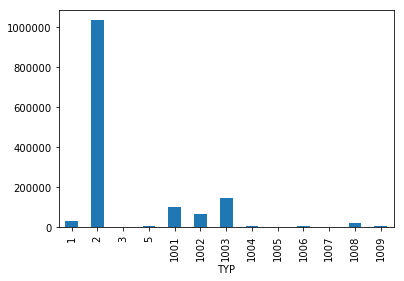

In [16]:
elems.groupby("TYP").TYP.count().plot(kind='bar')

## Ansys plots
You can extract ansys plots directly into a notebook. For that you can use the ``plot`` function of the ``Ansys`` object which will return the path to an image file which you can display in a notebook using the IPython.display.Image method.

In [17]:
img = a.plot("eplot")

In [18]:
from IPython.display import display, Image

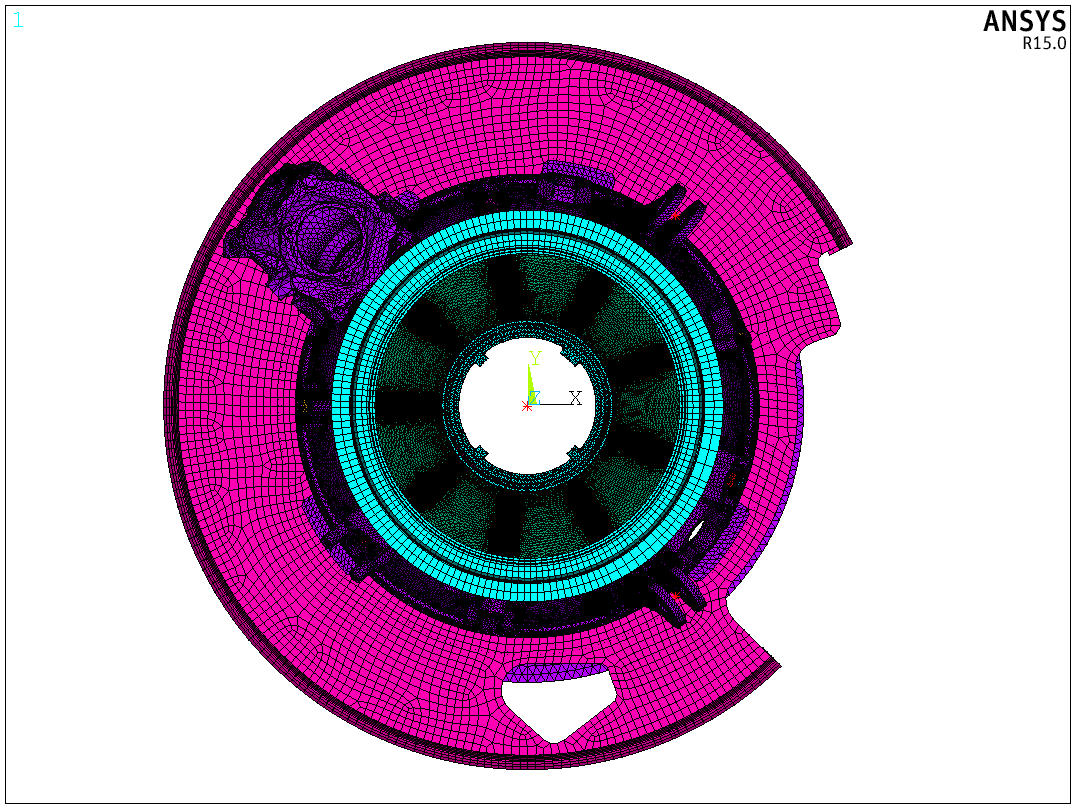

In [19]:
Image(img)

## Combing all above
In the following steps, let's try to list all the components in the current cdb file, filter out all elemental components and then take plots of all of them.

In [20]:
comps = a.get_list("cmlist", skiprows=3) 
# The skiprows argument is used since the cmlist command produces three irrelavant lines at the top of the output.
# For commands like nlist and elist, this number is 2 which is the default for the get_list function.

In [21]:
comps.head() # Displaying first 5 components

NAME  TYPE  SUBCOMPONENTS
0      AGBB1_NODES  NODE            NaN
1      AGBB2_NODES  NODE            NaN
2      AGBB3_NODES  NODE            NaN
3      AGBB4_NODES  NODE            NaN
4  AGBSPS1_2_NODES  NODE            NaN

In [22]:
elem_comps = comps[comps.TYPE == "ELEM"]

In [23]:
elem_comps.head(4) # Displaying first 4 elemental components.

NAME  TYPE  SUBCOMPONENTS
5   AGB_HOUSING  ELEM            NaN
11    AGB_PLATE  ELEM            NaN
13    B3SC_ELEM  ELEM            NaN
14   BLD25_ELEM  ELEM            NaN

Now let's select each of these components and plot them.

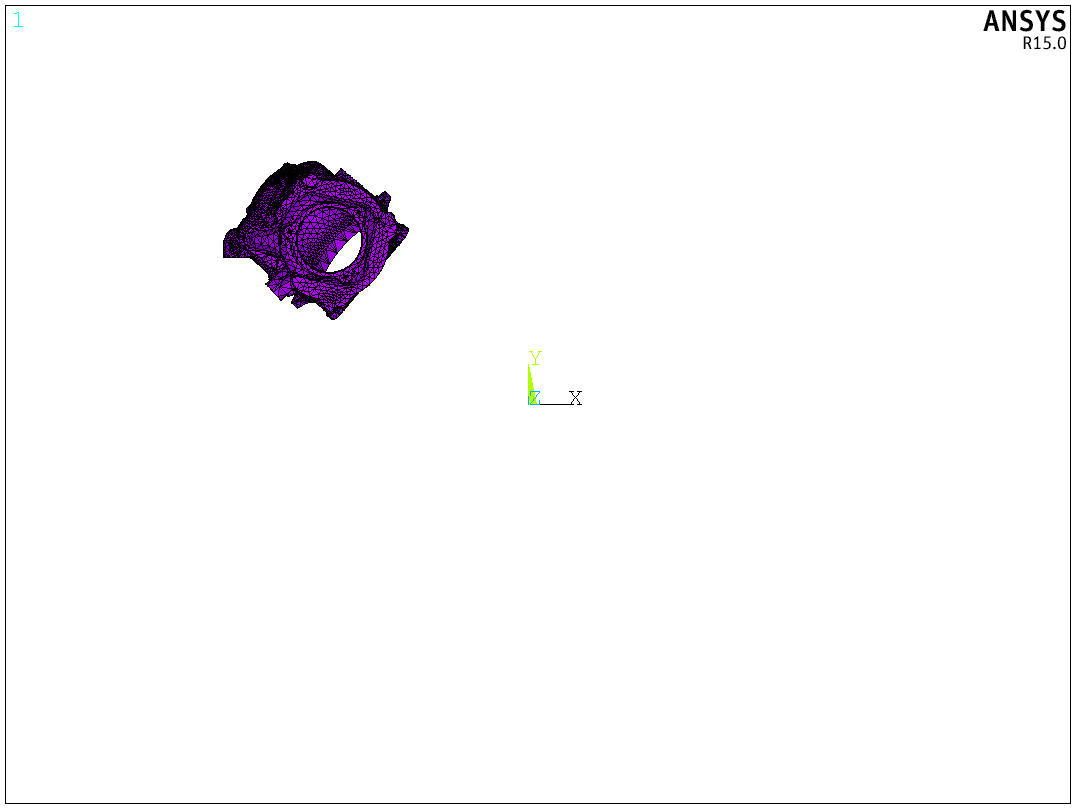

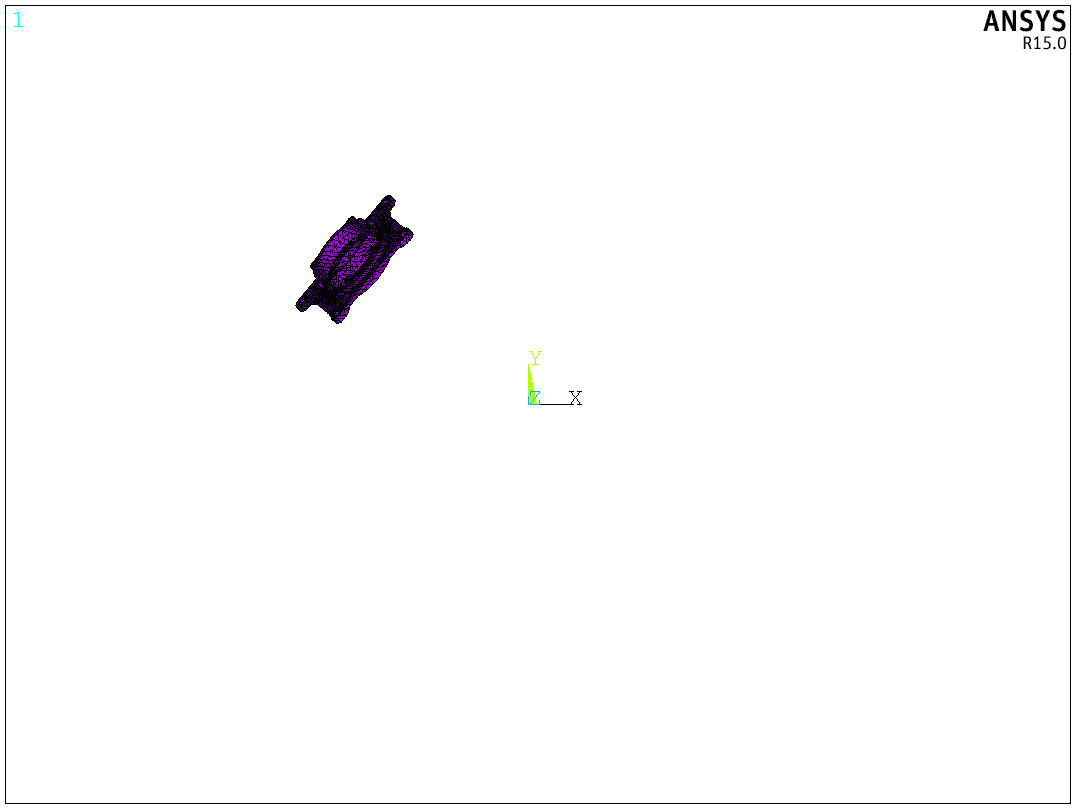

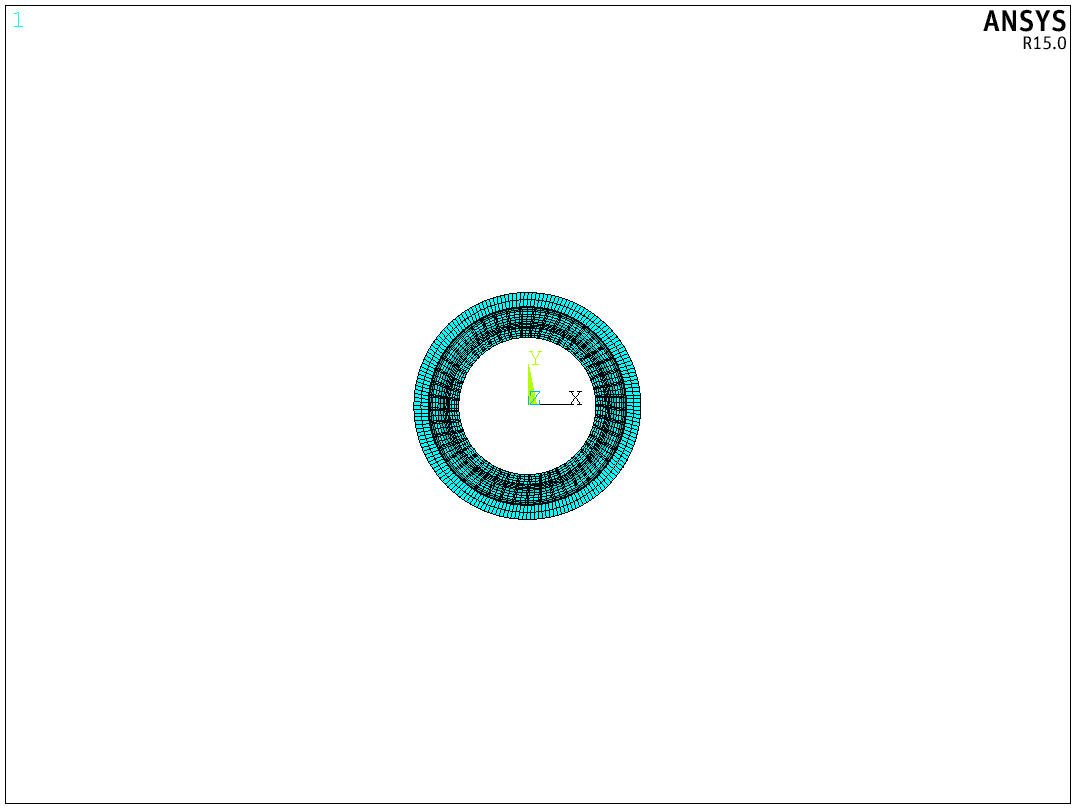

In [24]:
for comp in elem_comps.head(3).NAME:
    # Only the first 3 components are taken here for simplicity. If you want all components, remove the .head(3) part.
    a.send("cmsel,s,{}".format(comp))
    display(Image(a.plot("eplot"))) # The display function has to be used when you're using Image in a loop.